In [2]:
### MATPLOTLIB SETUP ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
pd.set_option('display.float_format', lambda x: '%e' % x)

## Amit's library with some utility functions for reading and processing scope data; reproduced below
sys.path.append("../../")
from lib import *

from rich.console import Console
from rich.syntax import Syntax
# Console().print(Syntax.from_path("../../lib.py", line_numbers=True, theme="monokai"))

## Jupyter magic
%matplotlib
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

Using matplotlib backend: ipympl
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


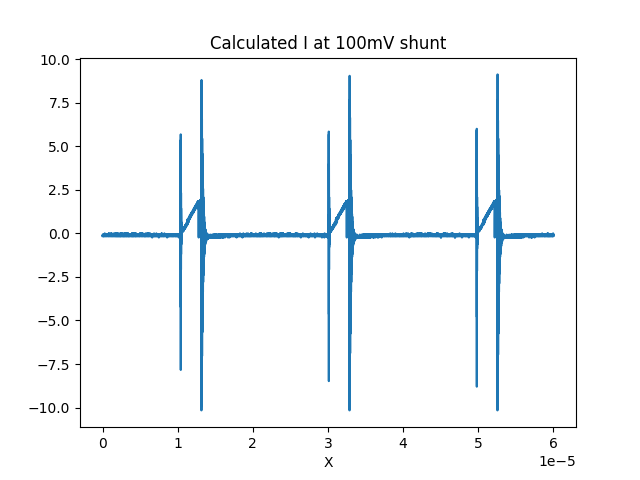

In [65]:
R = 5 # Load Resistance
V = 3.55  # Measured output voltages
Vg = 18 # Input Voltage
Fs = 50500 # Measured frequency
Ts = 1/ Fs
R_SHUNT = 0.05 # from schematic

data, _ = import_and_clean("100mV", ["Vshunt", "Vdrain"], False)
data['I_calc'] = data['Vshunt'] / R_SHUNT
V_L = Vg - V
data.plot(x="X", y="I_calc", legend=False, title=f"Calculated I at 100mV shunt")
rng = np.where((data["X"] > 3.04e-5) & (data["X"] < 3.18e-5))[0]
dI =np.polyfit(data["X"][rng[0]:rng[-1]], data["I_calc"][rng[0]:rng[-1]], 1)[0]
L1 = V_L/dI

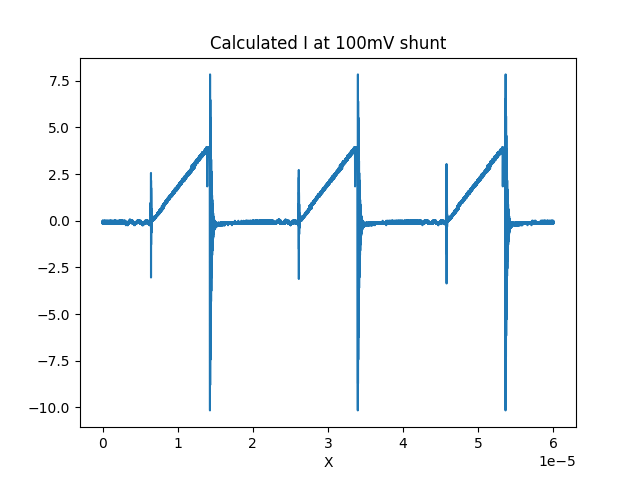

In [66]:
R = 5 # Load Resistance
V = 8.13  # Measured output voltages
Vg = 18 # Input Voltage
Fs = 50500 # Measured frequency
Ts = 1/ Fs
R_SHUNT = 0.05 # from schematic

data, _ = import_and_clean("200mV", ["Vshunt", "Vdrain"], False)
data['I_calc'] = data['Vshunt'] / R_SHUNT
V_L = Vg - V
data.plot(x="X", y="I_calc", legend=False, title=f"Calculated I at 100mV shunt")
rng = np.where((data["X"] > 2.8e-5) & (data["X"] < 3.2e-5))[0]
dI = np.polyfit(data["X"][rng[0]:rng[-1]], data["I_calc"][rng[0]:rng[-1]], 1)[0]
L2 = V_L/dI

In [67]:
(L1 + L2)/2

np.float64(1.8298208589629432e-05)